<a href="https://colab.research.google.com/github/Pradeep2535/Colab-Notebooks-for-GenAI/blob/main/Multimodal_RAG_using_Gemini_Langchain_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install langchain langchain-google-genai pypdf
clear_output()

In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate


In [ ]:
!pip install faiss-cpu langchain-community
clear_output()

In [ ]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.vectorstores import FAISS

In [ ]:
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [ ]:
llm(
    [

        HumanMessage(content="Hello, tell about prime misiter")
    ]
).content

'The term "prime minister" refers to the head of government in many parliamentary systems.  It\'s a crucial role, differing significantly from a president in a presidential system. Here\'s a breakdown of the key aspects:\n\n**Role and Responsibilities:**\n\n* **Head of Government:**  Unlike a head of state (like a president or monarch), the prime minister is primarily responsible for the day-to-day running of the government.  They lead the cabinet, which is composed of ministers heading various government departments.\n* **Legislative Power:**  The prime minister and their cabinet typically propose and guide legislation through the parliament (or legislature).  They need the support of parliament to pass laws and implement policies.\n* **Executive Power:**  The prime minister and cabinet are responsible for implementing laws and policies, overseeing the bureaucracy, and managing the country\'s affairs.\n* **Appointing Ministers:** The prime minister usually selects and appoints the mem

In [ ]:
import requests
from PIL import Image



In [ ]:
def get_image(url, filename, extension):
  content = requests.get(url).content
  with open(f'/content/{filename}.{extension}', 'wb') as f:
    f.write(content)
  image = Image.open(f'/content/{filename}.{extension}')
  image.show()
  image_data = base64.b64encode(requests.get(url).content).decode("utf-8")
  return image_data,image

In [ ]:
image,image_data = get_image("https://i5.walmartimages.com/asr/f02e247b-12d6-4ed7-a5fa-45fcdec6bdf1.d4801b402256f77ff1b0326b60cab241.jpeg", "image1","jpeg")

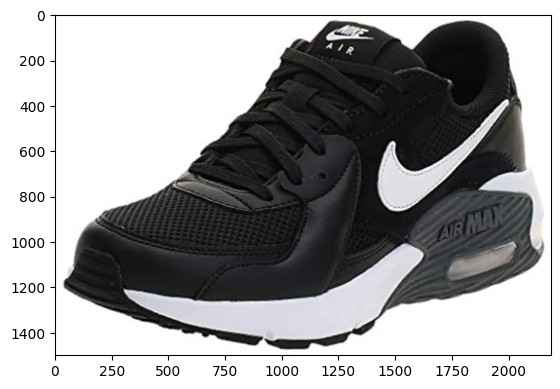

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_data)
plt.show()

In [ ]:
prompt = "give me summary of this image in 5 lines and who are you"

In [ ]:
message = [

    SystemMessage("You are a E-commerce assistant. So answer the queries asked by users. If anything other topics asked, respond that you don't know gently."),
    HumanMessage(
    content=[
          {"type": "text", "text": prompt},
          {
              "type": "image_url",
              "image_url": {"url": f"data:image/jpeg;base64,{image}"},
          },
      ],
    )
]

In [ ]:

response = llm.invoke(message)
print(response.content)

The image shows a black Nike Air Max sneaker with white accents.  The shoe has a mesh and leather upper, a visible Air Max unit in the heel, and a white midsole.  It's a classic sneaker design, appearing comfortable and stylish.  The Nike swoosh logo is prominently displayed on the side. The shoe is predominantly black with white accents.

I am an e-commerce assistant, here to help you with your shopping queries.



In [ ]:
from langchain.document_loaders import TextLoader

loader = TextLoader('/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG_Gemini/sneaker_samples.txt')

In [ ]:
text_data = loader.load()
text_data[0]

Document(metadata={'source': '/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG_Gemini/sneaker_samples.txt'}, page_content='\nNike Air Max Plus sneakers. They feature a brown upper with a black Nike Swoosh logo on the side and a visible Air Max unit in the heel. The sole is white.\nHere are some more details about the Nike Air Max Plus:\nStyle: TN\nRelease date: January 1, 2017\nStyle code: 852630-300\nOriginal retail price: $150 USD\nThe Air Max Plus, also known as the TN, is a popular Nike running shoe that was first released in 1998. It is known for its unique design, which includes a gradient upper, visible Air Max units, and a wavy outsole. The TN has been a popular shoe among sneakerheads and casual wearers alike for over two decades.\nIt features a brown upper with a black Swoosh logo and a white sole. The shoe is currently available for resale on the StockX marketplace for an average price of around $150 USD.\nNike Air Max Plus Store Location: "Kings Way, Kathmandu, Nepal".

In [ ]:
def get_text_chunks(text_data):
  text_splitter = CharacterTextSplitter(chunk_size=800, chunk_overlap=200)
  chunks = text_splitter.split_documents(text_data)
  return chunks


In [ ]:
docs = get_text_chunks(text_data)

In [ ]:
embeddings = GoogleGenerativeAIEmbeddings(model='models/embedding-001')

In [ ]:
vector_store = FAISS.from_documents(docs,embeddings)

In [ ]:
retriever = vector_store.as_retriever()
retriever.invoke("Nike airforce")

[Document(metadata={'source': '/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG_Gemini/sneaker_samples.txt'}, page_content='Nike Air Force 1 sneakers.\nHere are some more details about the Nike Air Force 1:\nStyle: High-top\nRelease date: March 1, 1982\nStyle code: AF1-001\nOriginal retail price: $90 USD\nThe Air Force 1 is one of Nike\'s most iconic basketball shoes. It is known for its simple design, durability, and comfort. The AF1 has been released in countless colorways and collaborations over the years, making it a favorite among sneaker enthusiasts.\nNike Air Force 1 Store Location: "New Road, Kathmandu, Nepal".'),
 Document(metadata={'source': '/content/drive/MyDrive/Colab Notebooks/Multimodal_RAG_Gemini/sneaker_samples.txt'}, page_content='Nike Air Force 1 sneakers.\nHere are some more details about the Nike Air Force 1:\nStyle: High-top\nRelease date: March 1, 1982\nStyle code: AF1-001\nOriginal retail price: $90 USD\nThe Air Force 1 is one of Nike\'s most iconic basketb

In [ ]:
template = """
```
{context}
```

{query}


Provide brief information about its features and store location.
Bold the heading, where the heading is product name. give features in points
"""

In [ ]:
from langchain.schema.runnable import RunnablePassthrough
prompt = ChatPromptTemplate.from_template(template)

In [ ]:
rag_chain = (
    {"context":retriever , "query" : RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
result = rag_chain.invoke("can you give me a detail of nike air force?")

In [ ]:
from IPython.display import Markdown, display
display(Markdown(result))

**Nike Air Force 1**

* Style: High-top
* Release date: March 1, 1982
* Style code: AF1-001
* Original retail price: $90 USD
* Known for its simple design, durability, and comfort.
* Released in countless colorways and collaborations.

Store Location: New Road, Kathmandu, Nepal


In [ ]:
full_chain = (
    RunnablePassthrough() | llm | StrOutputParser() | rag_chain
)


In [ ]:
full_chain

RunnablePassthrough()
| ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7831a2062b30>, default_metadata=())
| StrOutputParser()
| {
    context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x78317ea43d30>, search_kwargs={}),
    query: RunnablePassthrough()
  }
| ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='\n```\n{context}\n```\n\n{query}\n\n\nProvide brief information about its features and store location.\nBold the heading, where the heading is product name. give features in points\n'), additional_kwargs={})])
| ChatGoogleGenerativeAI(model

In [ ]:
url = "https://th.bing.com/th/id/OIP.XTk8VCBxquzyLTyOgFK0fwHaHa?rs=1&pid=ImgDetMain"

In [ ]:
image, image_data = get_image(url, "image2","jpg")

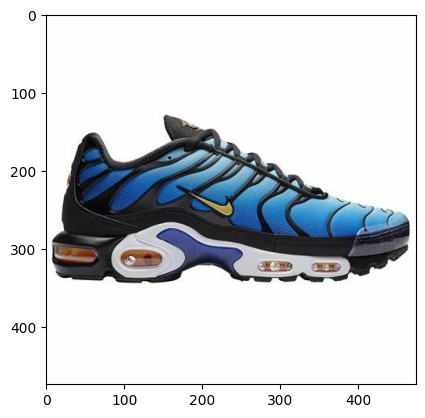

In [ ]:
plt.imshow(image_data)

In [ ]:
message = HumanMessage(
    content =  [
        {
            "type": "text",
            "text": "Provide information on given sandle image Brand and model.",
        },  # You can optionally provide text parts
        {"type": "image_url", "image_url": {"url": f"data:image/jpg;base64,{image}"},},
    ]
)

In [ ]:
result = full_chain.invoke([message])

In [ ]:
display(Markdown(result))

**Nike Air Max Plus**

* Brown upper
* Black Nike Swoosh logo
* Visible Air Max unit in the heel
* White sole
* Style: TN
* Style code: 852630-300 (Note: This style code may not correspond to the exact colorway described.)
* Originally released in 1998
* Known for its unique design, gradient upper, visible Air Max units, and wavy outsole.
* Available for resale on StockX.

Store Location: Kings Way, Kathmandu, Nepal.
